<a href="https://colab.research.google.com/github/RitaROK/Analysis/blob/main/Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 4.0 MB/s 


In [ ]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import uncertainties.unumpy as unp 
import scipy
from sklearn.metrics import mean_squared_error

def get_color(n, basecolor):
  current_palette = sns.dark_palette(n_colors=n, color=basecolor)
  sns.palplot(current_palette)
  colors = np.zeros(n, dtype=object)
  for color in range(n):
    colors[color] = current_palette[color]
  return colors

In [ ]:
roi = pd.read_csv('/content/drive/MyDrive/LIME/roi.csv')
original = pd.read_csv('/content/drive/MyDrive/LIME/sc.csv')
roi['R']=np.sqrt((roi['xMean']-(2304/2))**2+(roi['yMean']-(2304/2))**2) # Distance from the center
roi['TSigma'] = roi['TSigma']*155
roi['LSigma'] = roi['LSigma']*155
roi.describe()

,z[cm],Hits,Integral,Length,Width,Slim,PathLen,CorrIntegral,xMax,xMin,...,LAmp,LMean,LSigma,Long_RMS,MAmp,MFWHM,MMean,MProm,Pixel,R
count,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.0,251440.000000,251440.000000,251440.000000,...,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000
mean,24.402303,406.991577,7387.418094,37.527159,31.462311,0.840268,-1.0,28709.457663,1423.350016,1389.534839,...,1093.674008,18.637897,956.374380,5.878410,1228.683430,5.574327,18.819076,1162.892885,7129.694050,575.906634
std,12.406499,110.683815,1835.943276,4.963289,4.798911,0.086205,0.0,7095.156578,556.467129,556.087405,...,214.779881,3.070184,167.891613,0.917130,240.512170,1.734003,3.881874,247.476867,4599.808717,275.250941
min,0.000000,100.000000,1456.721000,19.000000,14.569679,0.600019,-1.0,6002.030000,223.000000,204.000000,...,300.603300,8.045532,406.694766,2.300020,403.312230,2.000282,5.500000,400.121250,0.000000,1.943643
25%,15.000000,326.000000,6137.715575,34.358808,27.888294,0.782432,-1.0,24335.557750,987.000000,952.000000,...,955.646050,16.560118,840.511405,5.259190,1072.313125,4.029987,16.000000,1001.251877,3424.000000,343.863777
50%,25.000000,412.000000,7534.881300,37.915604,31.737520,0.848713,-1.0,29134.941500,1519.000000,1484.000000,...,1092.255700,18.576963,964.927359,5.943493,1213.978650,5.707380,19.000000,1150.739000,6704.000000,575.465301
75%,35.000000,490.000000,8730.483500,41.027379,35.124967,0.901700,-1.0,33431.991500,1907.000000,1872.000000,...,1225.771125,20.597599,1075.545314,6.538057,1374.043250,6.965137,21.500000,1313.813050,10224.000000,813.210276
max,45.000000,798.000000,15159.720000,49.996555,49.548534,1.000000,-1.0,59992.797000,2207.000000,2192.000000,...,1994.883800,29.997269,1548.184175,8.998210,2093.593300,10.982183,35.000000,1999.858400,29472.000000,1175.128896


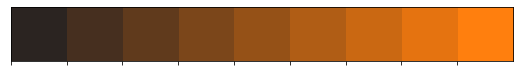

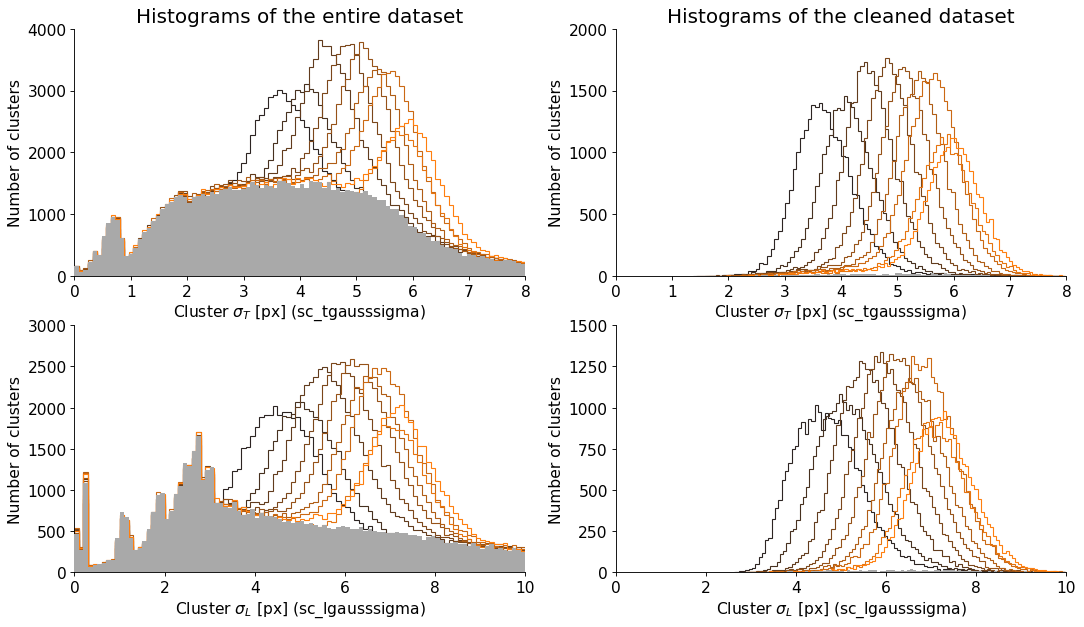

In [ ]:
#@title Influence of Data Cleaning 
nbin=100
color = get_color(9, 'tab:orange')
i=0

fig, (ax) = plt.subplots(2,2, figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
ax[0][0].set_title('Histograms of the entire dataset', fontsize=18)
ax[0][1].set_title('Histograms of the cleaned dataset', fontsize=18)

ax[0][0].hist(original['TSigma'].loc[(original['z[cm]']==0) & (original['TSigma']<8)], bins=nbin, color='darkgray', zorder=5)
ax[0][1].hist(roi['TSigma'].loc[roi['z[cm]']==0]/155, bins=nbin, color='darkgray', zorder=5)
ax[1][0].hist(original['LSigma'].loc[(original['z[cm]']==0) & (original['LSigma']<10)], bins=nbin, color='darkgray', zorder=5)
ax[1][1].hist(roi['LSigma'].loc[roi['z[cm]']==0]/155, bins=nbin, color='darkgray', zorder=5)

for dist in [5, 10, 15, 20, 25, 30, 35, 40, 45]:
  ax[0][0].hist(original['TSigma'].loc[(original['z[cm]']==dist) & (original['TSigma']<8)], bins=nbin, histtype='step', lw=1, color=color[i])
  ax[0][1].hist(roi['TSigma'].loc[roi['z[cm]']==dist]/155, bins=nbin, histtype='step', lw=1, color=color[i])
  ax[1][0].hist(original['LSigma'].loc[(original['z[cm]']==dist) & (original['LSigma']<10)], bins=nbin, histtype='step', lw=1, color=color[i])
  ax[1][1].hist(roi['LSigma'].loc[roi['z[cm]']==dist]/155, bins=nbin, histtype='step', lw=1, color=color[i])
  i=i+1

ax[0][0].set_xlim(0,8)
ax[0][0].spines["right"].set_visible(False)
ax[0][0].spines["top"].set_visible(False)
ax[0][0].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=14)
ax[0][0].tick_params(axis='both', which='major', labelsize=14)
ax[0][0].set_xlabel('Cluster $\sigma_T$ [px] (sc_tgausssigma)', x=0.5, ha='center', fontsize=14)
ax[0][0].set_ylim(0,4e3)

ax[1][0].set_xlim(0,10)
ax[1][0].spines["right"].set_visible(False)
ax[1][0].spines["top"].set_visible(False)
ax[1][0].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=14)
ax[1][0].tick_params(axis='both', which='major', labelsize=14)
ax[1][0].set_xlabel('Cluster $\sigma_L$ [px] (sc_lgausssigma)', x=0.5, ha='center', fontsize=14)
ax[1][0].set_ylim(0,3e3)

ax[0][1].set_xlim(0,8)
ax[0][1].spines["right"].set_visible(False)
ax[0][1].spines["top"].set_visible(False)
ax[0][1].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=14)
ax[0][1].tick_params(axis='both', which='major', labelsize=14)
ax[0][1].set_xlabel('Cluster $\sigma_T$ [px] (sc_tgausssigma)', x=0.5, ha='center', fontsize=14)
ax[0][1].set_ylim(0,2e3)

ax[1][1].set_xlim(0,10)
ax[1][1].spines["right"].set_visible(False)
ax[1][1].spines["top"].set_visible(False)
ax[1][1].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=14)
ax[1][1].tick_params(axis='both', which='major', labelsize=14)
ax[1][1].set_xlabel('Cluster $\sigma_L$ [px] (sc_lgausssigma)', x=0.5, ha='center', fontsize=14)
ax[1][1].set_ylim(0,1.5e3)

plt.show()

In [ ]:
#@title Fitting functions

def gauss(x,A,x0,s):
    return A*np.exp(-(x-x0)**2/(2*s**2))

def fit_tsigma(data, nbin):
  fig, (ax) = plt.subplots(2,5, figsize=(24,9), dpi= 80, facecolor='w', edgecolor='k') 
  # Background
  display('#'*100)
  print('BACKGROUND')
  n, bins, patches = ax[0][0].hist(data['TSigma'].loc[data['z[cm]']==0], bins=nbin, color='darkgray', zorder=5)
  bin_middles = (bins[1:]+bins[:-1])/2
  x = np.linspace(0,1300, 1000)
  bpopt, bpcov = curve_fit(gauss, bin_middles, n, p0=[data['TSigma'].loc[data['z[cm]']==0].max(), data['TSigma'].loc[data['z[cm]']==0].mean(), 10])
  bpcov = np.sqrt(np.diag(bpcov))
  ycalc = gauss(x, *bpopt)
  print('A=', ufloat(bpopt[0], bpcov[0]))
  print('x0=', ufloat(bpopt[1], bpcov[1]))
  print('sigma=', ufloat(bpopt[2], bpcov[2]))
  def double_gauss(x,A,X0,S):
    return A*np.exp(-(x-X0)**2/(2*S**2))+abs(bpopt[0])*np.exp(-(x-abs(bpopt[1]))**2/(2*abs(bpopt[2])**2))
  #chi, p = scipy.stats.chisquare(n, f_exp=gauss(bin_middles, *bpopt), ddof=len(bin_middles)-3, axis=0)
  #print('Chi2 =', chi, 'P-value =', p)
  #print('Maximum chi value:', scipy.stats.chi2.ppf(1-0.05, df=len(bin_middles)-3))
  ax[0][0].plot(x, ycalc, color='k', zorder=5)
  sigma = []
  dsigma = []
  i = 1
  j = 0
  for depth in [5, 10, 15, 20, 25, 30, 35, 40, 45]:
    # Background
    ax[j][i].hist(data['TSigma'].loc[data['z[cm]']==0], bins=nbin, color='darkgray', zorder=5)
    # Signal
    display('#'*100)
    print('Z = ', depth)
    n, bins, patches = ax[j][i].hist(data['TSigma'].loc[data['z[cm]']==depth], bins=nbin, histtype='step', lw=1, color='tab:orange', label = 'Z='+str(depth)+'cm')
    bin_middles = (bins[1:]+bins[:-1])/2
    popt, pcov = curve_fit(double_gauss, bin_middles, n, p0=[data['TSigma'].loc[data['z[cm]']==depth].max(), data['TSigma'].loc[data['z[cm]']==depth].mean(), 10])
    ycalc = double_gauss(x, *popt)
    pcov = np.sqrt(np.diag(pcov))
    print('A =', ufloat(popt[0], pcov[0]))
    print('x0 = ', ufloat(popt[1], pcov[1]))
    print('sigma = ', ufloat(popt[2], pcov[2]))
    sigma.append(popt[1])
    dsigma.append(pcov[1])
    #chi, p = scipy.stats.chisquare(f_obs=n, f_exp=double_gauss(bin_middles, *popt), ddof=len(bin_middles)-3, axis=0)
    #print('Chi2 =', chi, 'P-value =', p)
    #print('Maximum chi value:', scipy.stats.chi2.ppf(1-0.05, df=len(bin_middles)-3))
    ax[j][i].plot(x, ycalc, color='k', zorder=5)
    ax[j][i].legend(loc='best')
    i=i+1
    if i>4:
      j = 1
      i = i-5
  plt.show()
  return sigma, dsigma

# Transverse Diffusion

'####################################################################################################'

BACKGROUND
A= 7.72+/-0.32
x0= 741+/-9
sigma= 183+/-9


'####################################################################################################'

Z =  5
A = 679+/-4
x0 =  567.8+/-0.6
sigma =  75.6+/-0.6


'####################################################################################################'

Z =  10
A = 689+/-4
x0 =  635.4+/-0.4
sigma =  71.2+/-0.4


'####################################################################################################'

Z =  15
A = 830+/-5
x0 =  694.7+/-0.5
sigma =  68.0+/-0.5


'####################################################################################################'

Z =  20
A = 841+/-4
x0 =  750.6+/-0.4
sigma =  67.9+/-0.4


'####################################################################################################'

Z =  25
A = 815+/-4
x0 =  795.5+/-0.4
sigma =  68.0+/-0.4


'####################################################################################################'

Z =  30
A = 790+/-4
x0 =  834.8+/-0.4
sigma =  69.0+/-0.4


'####################################################################################################'

Z =  35
A = 799+/-4
x0 =  872.2+/-0.4
sigma =  71.7+/-0.4


'####################################################################################################'

Z =  40
A = 537.8+/-3.0
x0 =  905.1+/-0.5
sigma =  72.6+/-0.5


'####################################################################################################'

Z =  45
A = 531.8+/-3.0
x0 =  928.6+/-0.5
sigma =  73.3+/-0.5


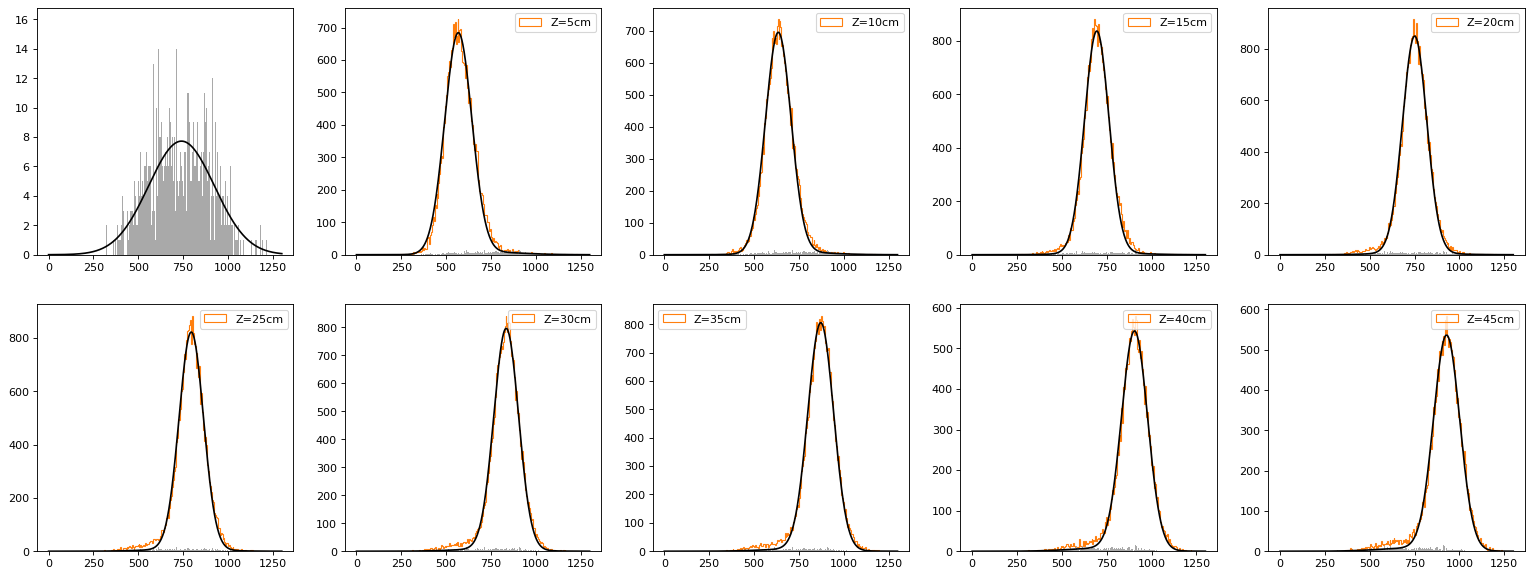

In [ ]:
#@title Average $\sigma_T$ for all CoIs

allcoi, dallcoi = fit_tsigma(roi, 200)

## Average $\sigma_T$ for different slices

'####################################################################################################'

BACKGROUND
A= 0.50+/-0.15
x0= 785+/-26
sigma= 77+/-26


'####################################################################################################'

Z =  5
A = 46.1+/-1.8
x0 =  573.5+/-3.1
sigma =  67.5+/-3.1


'####################################################################################################'

Z =  10
A = 51.9+/-1.5
x0 =  649.2+/-2.0
sigma =  62.8+/-2.0


'####################################################################################################'

Z =  15
A = 56.8+/-1.8
x0 =  702.5+/-2.2
sigma =  62.9+/-2.2


'####################################################################################################'

Z =  20
A = 73.6+/-1.5
x0 =  756.3+/-1.4
sigma =  56.9+/-1.4


'####################################################################################################'

Z =  25
A = 71.4+/-2.3
x0 =  805.4+/-2.2
sigma =  59.5+/-2.2


'####################################################################################################'

Z =  30
A = 64.5+/-1.6
x0 =  844.3+/-1.7
sigma =  59.2+/-1.7


'####################################################################################################'

Z =  35
A = 80.2+/-2.1
x0 =  888.3+/-1.8
sigma =  61.0+/-1.8


'####################################################################################################'

Z =  40
A = 46.7+/-1.0
x0 =  915.7+/-1.5
sigma =  59.6+/-1.5


'####################################################################################################'

Z =  45
A = 65.6+/-1.8
x0 =  936.8+/-2.0
sigma =  -62.6+/-2.0


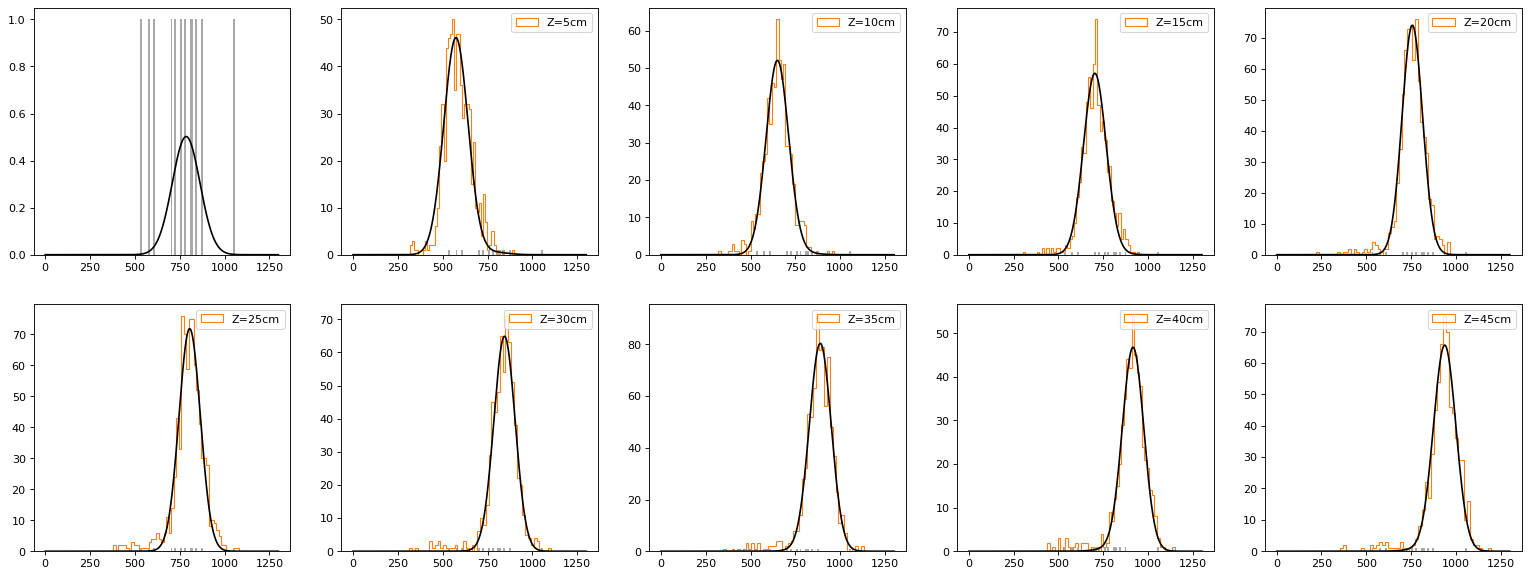

In [ ]:
#@title $\sigma_T$ for $0\leq R\leq100$
coi100, dcoi100 = fit_tsigma(roi.loc[(roi['R']<=100)], 50)

'####################################################################################################'

BACKGROUND
A= (0.0+/-2.1)e+06
x0= (0.0+/-1.3)e+10
sigma= (0.0+/-3.2)e+09


'####################################################################################################'

Z =  5
A = 178+/-4
x0 =  570.4+/-1.5
sigma =  63.9+/-1.5


'####################################################################################################'

Z =  10
A = 155.6+/-2.8
x0 =  640.1+/-1.3
sigma =  64.7+/-1.3


'####################################################################################################'

Z =  15
A = 193.4+/-2.4
x0 =  699.4+/-0.9
sigma =  62.8+/-0.9


'####################################################################################################'

Z =  20
A = 202.2+/-3.5
x0 =  753.2+/-1.2
sigma =  59.9+/-1.2


'####################################################################################################'

Z =  25
A = 234+/-4
x0 =  796.6+/-1.3
sigma =  60.2+/-1.3


'####################################################################################################'

Z =  30
A = 192.2+/-3.2
x0 =  838.7+/-1.2
sigma =  60.0+/-1.2


'####################################################################################################'

Z =  35
A = 216.8+/-3.1
x0 =  873.9+/-1.0
sigma =  62.4+/-1.0


'####################################################################################################'

Z =  40
A = 130.0+/-2.4
x0 =  909.4+/-1.4
sigma =  63.9+/-1.4


'####################################################################################################'

Z =  45
A = 171.2+/-2.6
x0 =  935.0+/-1.2
sigma =  67.8+/-1.2


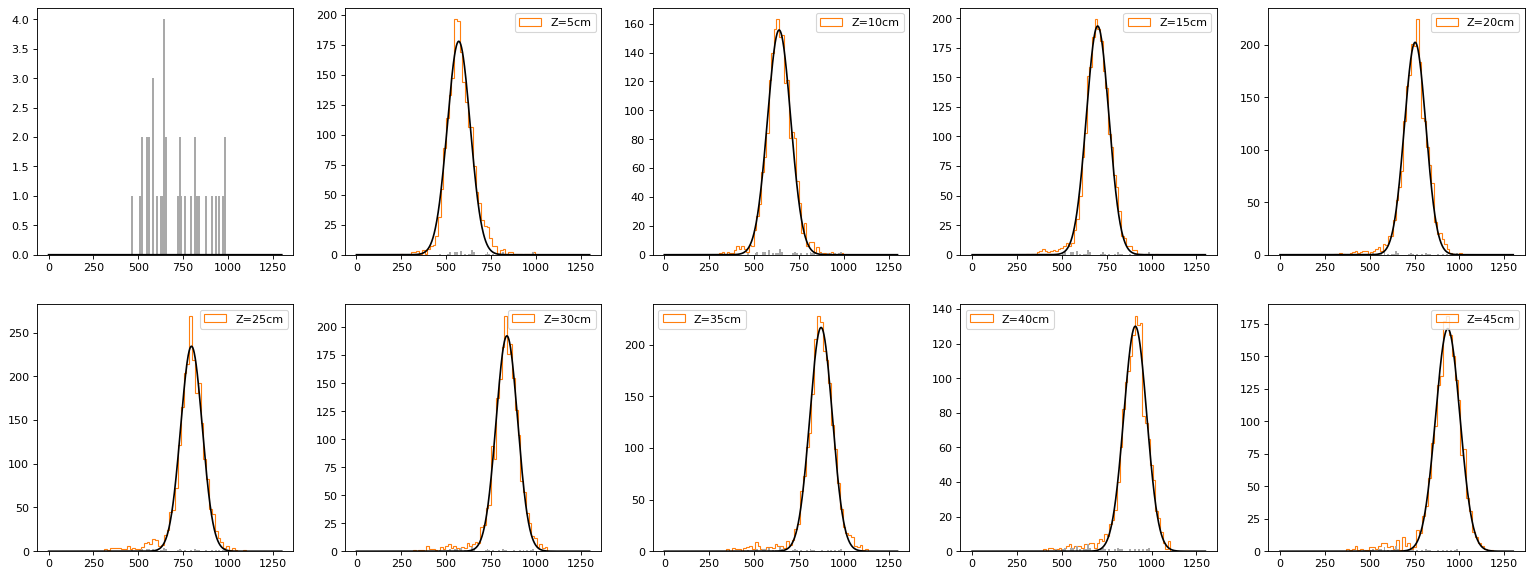

In [ ]:
#@title $\sigma_T$ for $100<R\leq 200$
coi200, dcoi200 = fit_tsigma(roi.loc[(roi['R']<=200) & (roi['R']>100)], 50)

'####################################################################################################'

BACKGROUND
A= 1.85+/-0.24
x0= 709+/-32
sigma= (1.9+/-0.4)e+02


'####################################################################################################'

Z =  5
A = 217+/-5
x0 =  577.2+/-1.6
sigma =  65.5+/-1.6


'####################################################################################################'

Z =  10
A = 287+/-5
x0 =  644.4+/-1.3
sigma =  60.2+/-1.3


'####################################################################################################'

Z =  15
A = 329+/-5
x0 =  702.1+/-1.1
sigma =  58.4+/-1.1


'####################################################################################################'

Z =  20
A = 316+/-5
x0 =  758.9+/-1.0
sigma =  60.0+/-1.0


'####################################################################################################'

Z =  25
A = 304.3+/-3.0
x0 =  801.4+/-0.7
sigma =  59.1+/-0.7


'####################################################################################################'

Z =  30
A = 276+/-4
x0 =  836.7+/-0.9
sigma =  61.4+/-0.9


'####################################################################################################'

Z =  35
A = 307+/-4
x0 =  874.9+/-0.9
sigma =  63.4+/-0.9


'####################################################################################################'

Z =  40
A = 234+/-4
x0 =  908.1+/-1.4
sigma =  62.6+/-1.4


'####################################################################################################'

Z =  45
A = 239.7+/-3.2
x0 =  935.7+/-1.0
sigma =  65.8+/-1.0


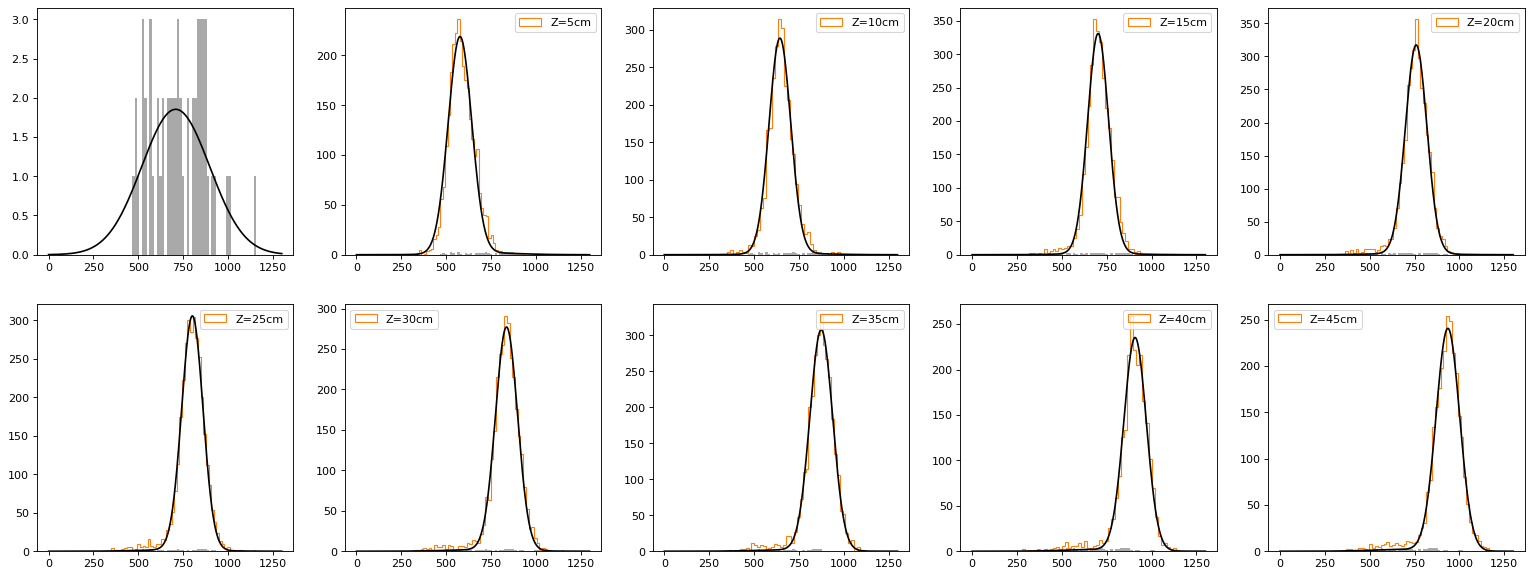

In [ ]:
#@title $\sigma_T$ for $200<R\leq 300$
coi300, dcoi300 = fit_tsigma(roi.loc[(roi['R']<=300) & (roi['R']>200)], 50)

'####################################################################################################'

BACKGROUND
A= (0.0+/-1.0)e+03
x0= (7.1+/-0.4)e+02
sigma= (0+/-9)e+01


'####################################################################################################'

Z =  5
A = 69.3+/-0.9
x0 =  584.6+/-1.0
sigma =  66.9+/-1.0


'####################################################################################################'

Z =  10
A = 57.0+/-0.8
x0 =  644.4+/-1.1
sigma =  64.8+/-1.1


'####################################################################################################'

Z =  15
A = 74.2+/-1.0
x0 =  701.8+/-1.0
sigma =  63.6+/-1.0


'####################################################################################################'

Z =  20
A = 88.8+/-1.2
x0 =  757.5+/-1.0
sigma =  61.3+/-1.0


'####################################################################################################'

Z =  25
A = 76.4+/-1.0
x0 =  800.2+/-0.9
sigma =  61.7+/-0.9


'####################################################################################################'

Z =  30
A = 71.0+/-1.0
x0 =  839.3+/-1.0
sigma =  64.4+/-1.0


'####################################################################################################'

Z =  35
A = 77.0+/-0.8
x0 =  875.1+/-0.8
sigma =  65.8+/-0.8


'####################################################################################################'

Z =  40
A = 57.6+/-0.8
x0 =  906.2+/-1.0
sigma =  64.3+/-1.0


'####################################################################################################'

Z =  45
A = 59.1+/-0.9
x0 =  928.7+/-1.2
sigma =  67.0+/-1.2


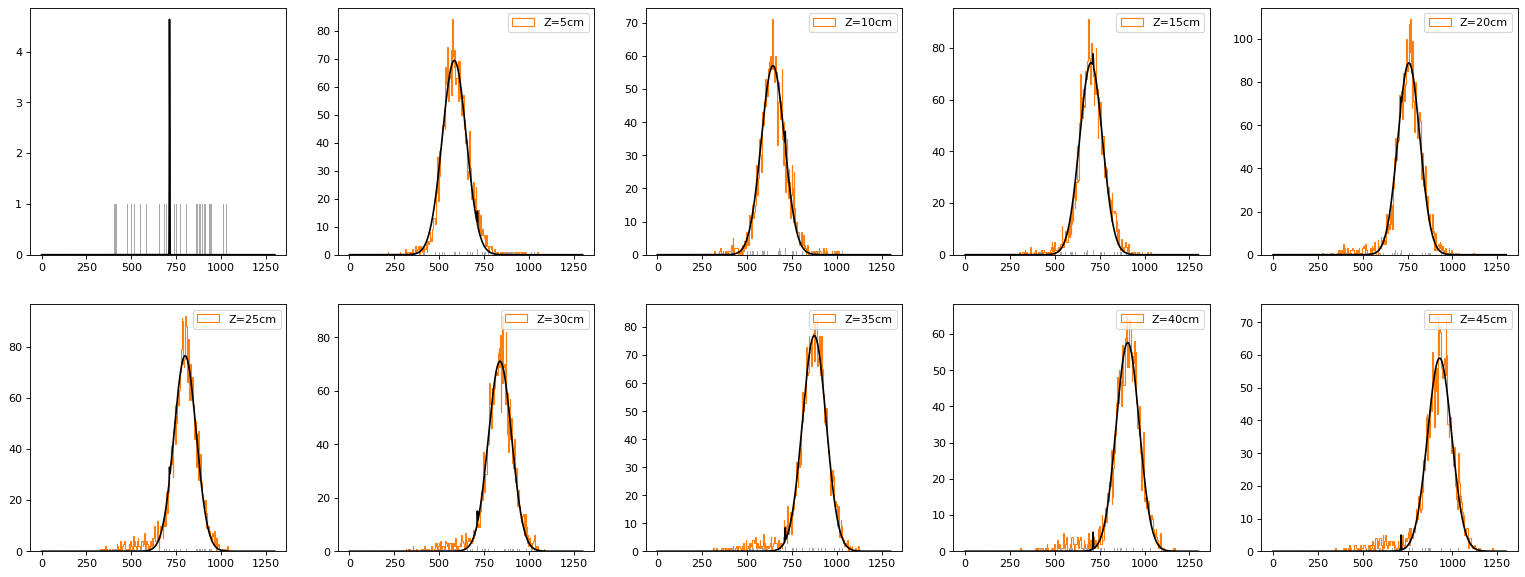

In [ ]:
#@title $\sigma_T$ for $300<R\leq 400$
coi400, dcoi400 = fit_tsigma(roi.loc[(roi['R']<=400) & (roi['R']>300)], 200)

'####################################################################################################'

BACKGROUND
A= 0.77+/-0.09
x0= 700+/-22
sigma= 166+/-25


'####################################################################################################'

Z =  5
A = 56.1+/-0.9
x0 =  576.8+/-1.4
sigma =  73.3+/-1.4


'####################################################################################################'

Z =  10
A = 69.7+/-1.0
x0 =  639.4+/-1.1
sigma =  68.7+/-1.1


'####################################################################################################'

Z =  15
A = 86.7+/-1.0
x0 =  697.6+/-0.8
sigma =  65.3+/-0.8


'####################################################################################################'

Z =  20
A = 70.8+/-1.0
x0 =  755.2+/-1.0
sigma =  64.2+/-1.0


'####################################################################################################'

Z =  25
A = 69.0+/-1.0
x0 =  795.1+/-1.0
sigma =  61.7+/-1.0


'####################################################################################################'

Z =  30
A = 65.7+/-0.7
x0 =  837.2+/-0.8
sigma =  65.4+/-0.8


'####################################################################################################'

Z =  35
A = 83.4+/-1.1
x0 =  872.6+/-1.0
sigma =  67.6+/-1.0


'####################################################################################################'

Z =  40
A = 51.5+/-0.7
x0 =  903.9+/-1.1
sigma =  66.8+/-1.1


'####################################################################################################'

Z =  45
A = 52.9+/-0.8
x0 =  922.6+/-1.1
sigma =  67.3+/-1.1


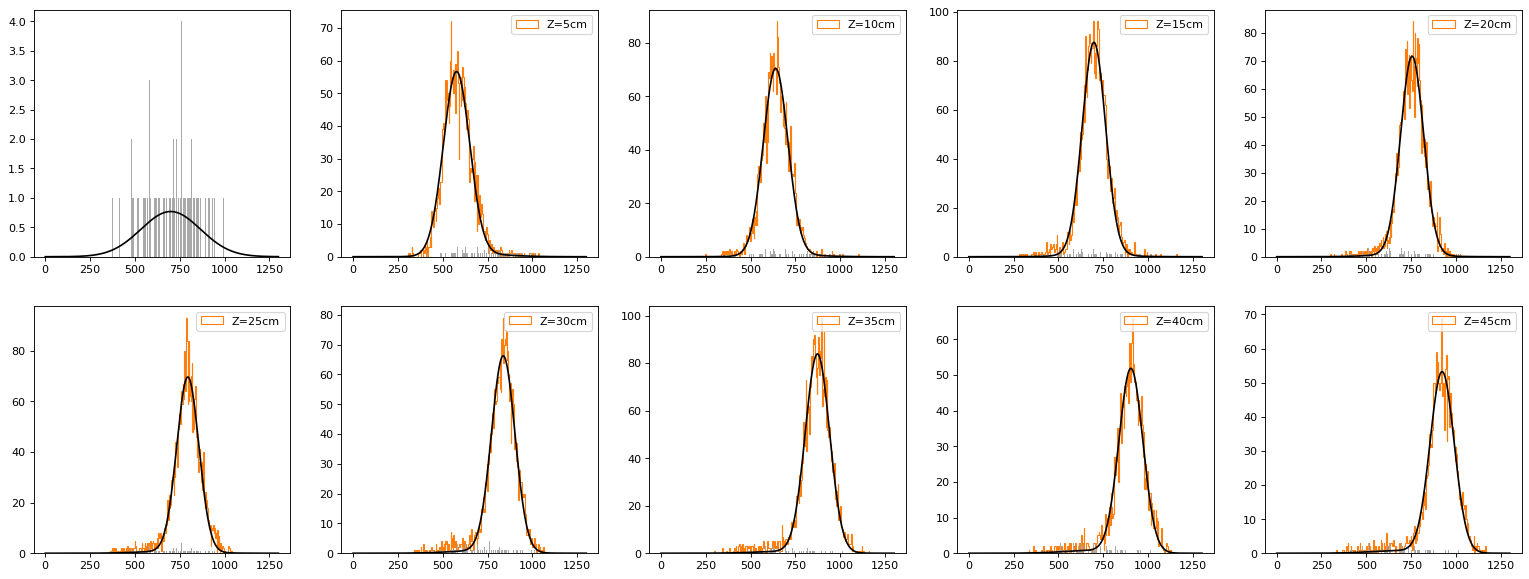

In [ ]:
#@title $\sigma_T$ for $400<R\leq 500$
coi500, dcoi500 = fit_tsigma(roi.loc[(roi['R']<=500) & (roi['R']>400)], 200)

'####################################################################################################'

BACKGROUND
A= 0.84+/-0.10
x0= 708+/-24
sigma= 178+/-24


'####################################################################################################'

Z =  5
A = 55.8+/-0.8
x0 =  546.2+/-1.3
sigma =  76.1+/-1.3


'####################################################################################################'

Z =  10
A = 52.6+/-0.8
x0 =  617.5+/-1.2
sigma =  69.6+/-1.2


'####################################################################################################'

Z =  15
A = 73.8+/-1.1
x0 =  679.8+/-1.2
sigma =  70.2+/-1.2


'####################################################################################################'

Z =  20
A = 67.4+/-0.8
x0 =  738.6+/-0.9
sigma =  69.1+/-0.9


'####################################################################################################'

Z =  25
A = 71.4+/-0.8
x0 =  783.6+/-0.9
sigma =  68.1+/-0.9


'####################################################################################################'

Z =  30
A = 62.3+/-0.9
x0 =  825.1+/-1.1
sigma =  68.5+/-1.1


'####################################################################################################'

Z =  35
A = 68.0+/-0.9
x0 =  861.2+/-1.1
sigma =  73.3+/-1.1


'####################################################################################################'

Z =  40
A = 54.5+/-0.9
x0 =  895.8+/-1.3
sigma =  72.1+/-1.3


'####################################################################################################'

Z =  45
A = 51.8+/-0.8
x0 =  917.0+/-1.3
sigma =  71.8+/-1.3


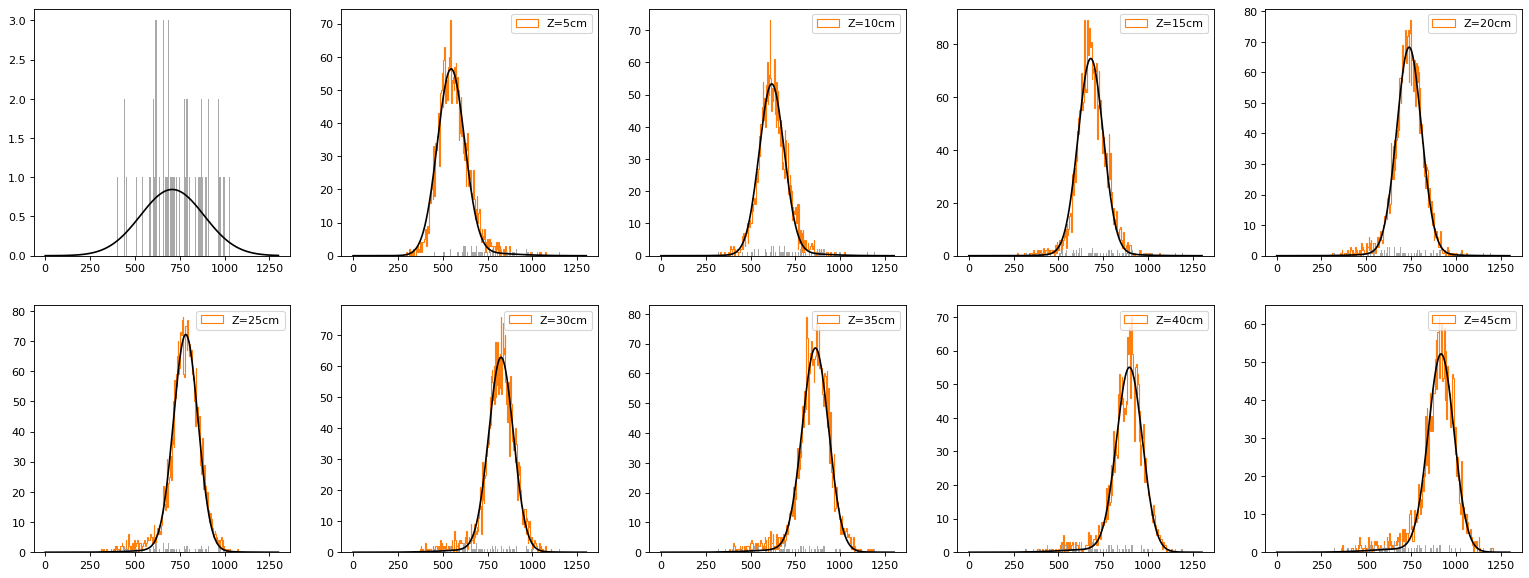

In [ ]:
#@title $\sigma_T$ for $500<R\leq 600$
coi600, dcoi600 = fit_tsigma(roi.loc[(roi['R']<=600) & (roi['R']>500)], 200)

'####################################################################################################'

BACKGROUND
A= 0.43+/-0.07
x0= (8.6+/-1.0)e+02
sigma= (2.8+/-1.2)e+02


'####################################################################################################'

Z =  5
A = 51.4+/-0.8
x0 =  534.9+/-1.4
sigma =  79.4+/-1.4


'####################################################################################################'

Z =  10
A = 49.6+/-0.9
x0 =  608.7+/-1.5
sigma =  74.5+/-1.5


'####################################################################################################'

Z =  15
A = 79.3+/-0.8
x0 =  670.9+/-0.8
sigma =  68.4+/-0.8


'####################################################################################################'

Z =  20
A = 71.0+/-0.9
x0 =  726.2+/-1.0
sigma =  68.6+/-1.0


'####################################################################################################'

Z =  25
A = 74.5+/-1.0
x0 =  776.3+/-1.1
sigma =  72.5+/-1.1


'####################################################################################################'

Z =  30
A = 63.6+/-0.8
x0 =  816.1+/-1.1
sigma =  71.5+/-1.1


'####################################################################################################'

Z =  35
A = 64.8+/-0.8
x0 =  852.4+/-1.1
sigma =  76.1+/-1.1


'####################################################################################################'

Z =  40
A = 52.8+/-0.8
x0 =  886.6+/-1.4
sigma =  78.8+/-1.4


'####################################################################################################'

Z =  45
A = 46.9+/-0.7
x0 =  912.9+/-1.3
sigma =  74.6+/-1.3


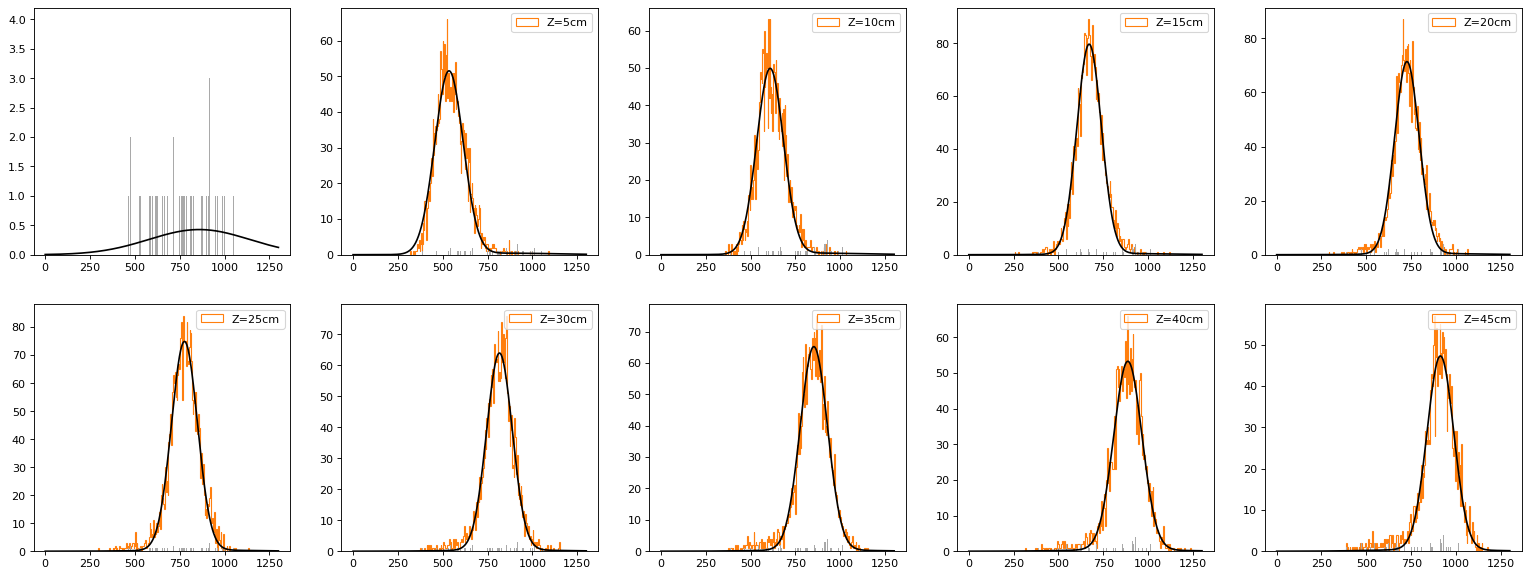

In [ ]:
#@title $\sigma_T$ for $600<R\leq 700$
coi700, dcoi700 = fit_tsigma(roi.loc[(roi['R']<=700) & (roi['R']>600)], 200)

'####################################################################################################'

BACKGROUND
A= 0.81+/-0.10
x0= 763+/-28
sigma= 196+/-30


'####################################################################################################'

Z =  5
A = 56.6+/-0.9
x0 =  540.1+/-1.5
sigma =  74.9+/-1.5


'####################################################################################################'

Z =  10
A = 54.6+/-0.7
x0 =  611.6+/-1.0
sigma =  71.0+/-1.0


'####################################################################################################'

Z =  15
A = 75.9+/-0.9
x0 =  674.9+/-0.9
sigma =  67.5+/-0.9


'####################################################################################################'

Z =  20
A = 78.1+/-0.9
x0 =  730.8+/-0.9
sigma =  68.2+/-0.9


'####################################################################################################'

Z =  25
A = 65.6+/-0.8
x0 =  777.1+/-0.9
sigma =  69.9+/-0.9


'####################################################################################################'

Z =  30
A = 66.8+/-0.9
x0 =  818.1+/-1.1
sigma =  72.0+/-1.1


'####################################################################################################'

Z =  35
A = 74.9+/-1.0
x0 =  859.0+/-1.2
sigma =  75.6+/-1.2


'####################################################################################################'

Z =  40
A = 41.8+/-0.7
x0 =  889.6+/-1.4
sigma =  76.2+/-1.4


'####################################################################################################'

Z =  45
A = 44.8+/-0.7
x0 =  917.2+/-1.5
sigma =  79.4+/-1.5


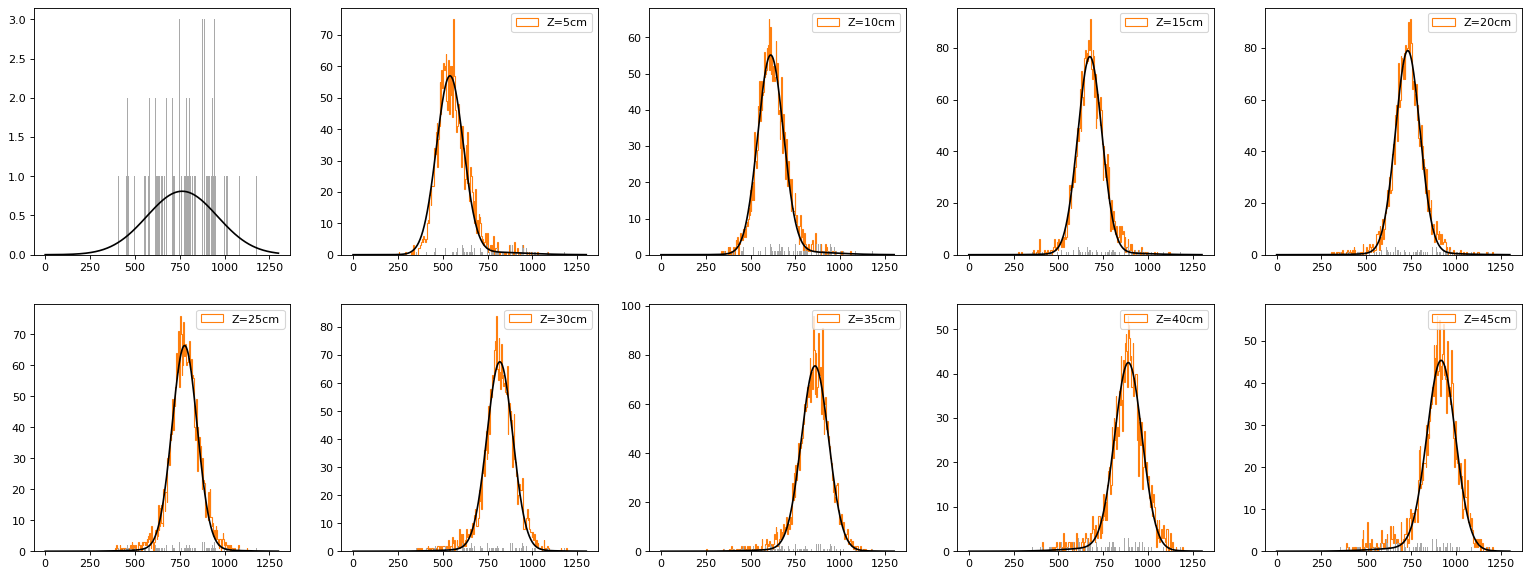

In [ ]:
#@title $\sigma_T$ for $700<R\leq 800$
coi800, dcoi800 = fit_tsigma(roi.loc[(roi['R']<=800) & (roi['R']>700)], 200)

'####################################################################################################'

BACKGROUND
A= 0.89+/-0.09
x0= 745+/-21
sigma= 176+/-22


'####################################################################################################'

Z =  5
A = 55.8+/-0.9
x0 =  562.5+/-1.5
sigma =  75.5+/-1.5


'####################################################################################################'

Z =  10
A = 54.0+/-0.7
x0 =  633.3+/-1.1
sigma =  71.0+/-1.1


'####################################################################################################'

Z =  15
A = 83.9+/-1.0
x0 =  694.9+/-0.9
sigma =  65.4+/-0.9


'####################################################################################################'

Z =  20
A = 74.0+/-1.0
x0 =  747.1+/-1.1
sigma =  71.6+/-1.1


'####################################################################################################'

Z =  25
A = 68.6+/-0.9
x0 =  796.2+/-1.1
sigma =  74.2+/-1.1


'####################################################################################################'

Z =  30
A = 81.4+/-0.9
x0 =  835.9+/-1.0
sigma =  72.4+/-1.0


'####################################################################################################'

Z =  35
A = 69.8+/-0.9
x0 =  874.4+/-1.1
sigma =  76.1+/-1.1


'####################################################################################################'

Z =  40
A = 53.0+/-0.7
x0 =  909.7+/-1.3
sigma =  80.0+/-1.3


'####################################################################################################'

Z =  45
A = 47.9+/-0.7
x0 =  929.0+/-1.3
sigma =  76.6+/-1.3


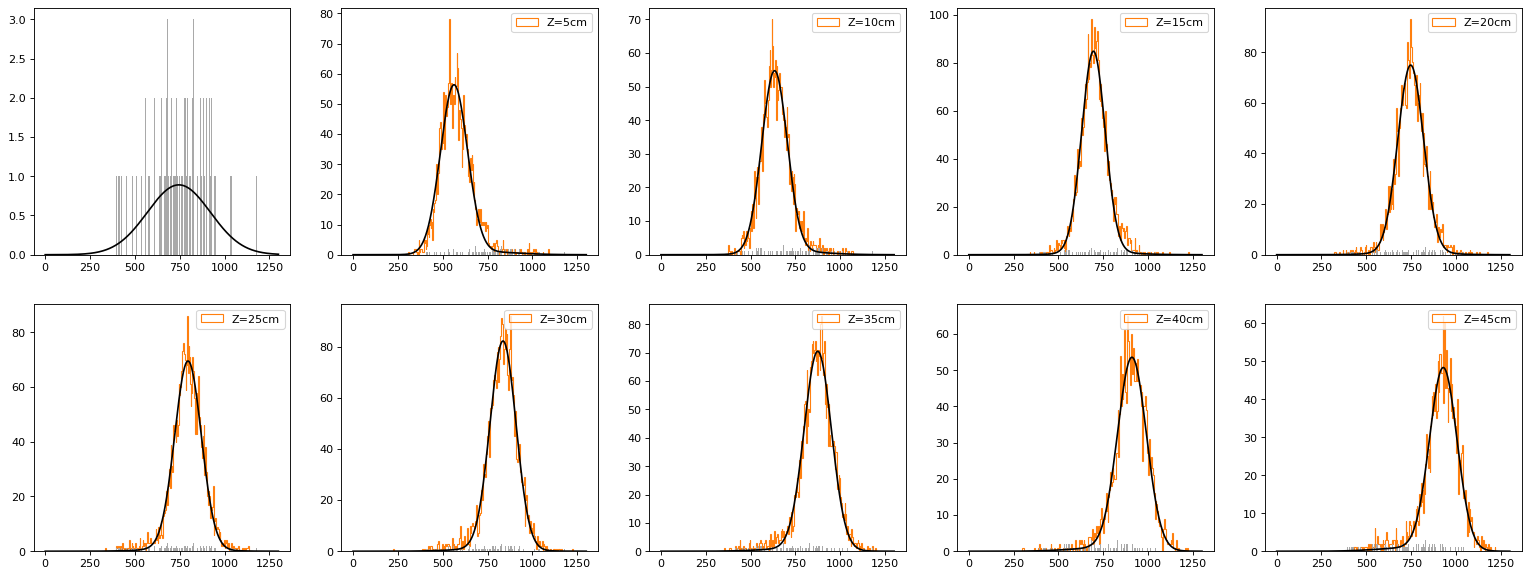

In [ ]:
#@title $\sigma_T$ for $800<R\leq 900$
coi900, dcoi900 = fit_tsigma(roi.loc[(roi['R']<=900) & (roi['R']>800)], 200)

'####################################################################################################'

BACKGROUND
A= 0.64+/-0.08
x0= 789+/-27
sigma= 164+/-30


'####################################################################################################'

Z =  5
A = 53.3+/-0.7
x0 =  588.7+/-1.2
sigma =  76.8+/-1.2


'####################################################################################################'

Z =  10
A = 49.2+/-0.7
x0 =  657.9+/-1.2
sigma =  72.6+/-1.2


'####################################################################################################'

Z =  15
A = 73.2+/-0.9
x0 =  715.9+/-1.0
sigma =  72.3+/-1.0


'####################################################################################################'

Z =  20
A = 64.3+/-0.9
x0 =  773.0+/-1.2
sigma =  73.0+/-1.2


'####################################################################################################'

Z =  25
A = 67.7+/-0.8
x0 =  820.0+/-1.0
sigma =  73.2+/-1.0


'####################################################################################################'

Z =  30
A = 64.2+/-0.9
x0 =  856.8+/-1.1
sigma =  74.4+/-1.1


'####################################################################################################'

Z =  35
A = 67.8+/-0.9
x0 =  893.0+/-1.2
sigma =  76.6+/-1.2


'####################################################################################################'

Z =  40
A = 41.5+/-0.6
x0 =  927.8+/-1.5
sigma =  81.0+/-1.5


'####################################################################################################'

Z =  45
A = 50.6+/-0.7
x0 =  947.7+/-1.4
sigma =  81.2+/-1.4


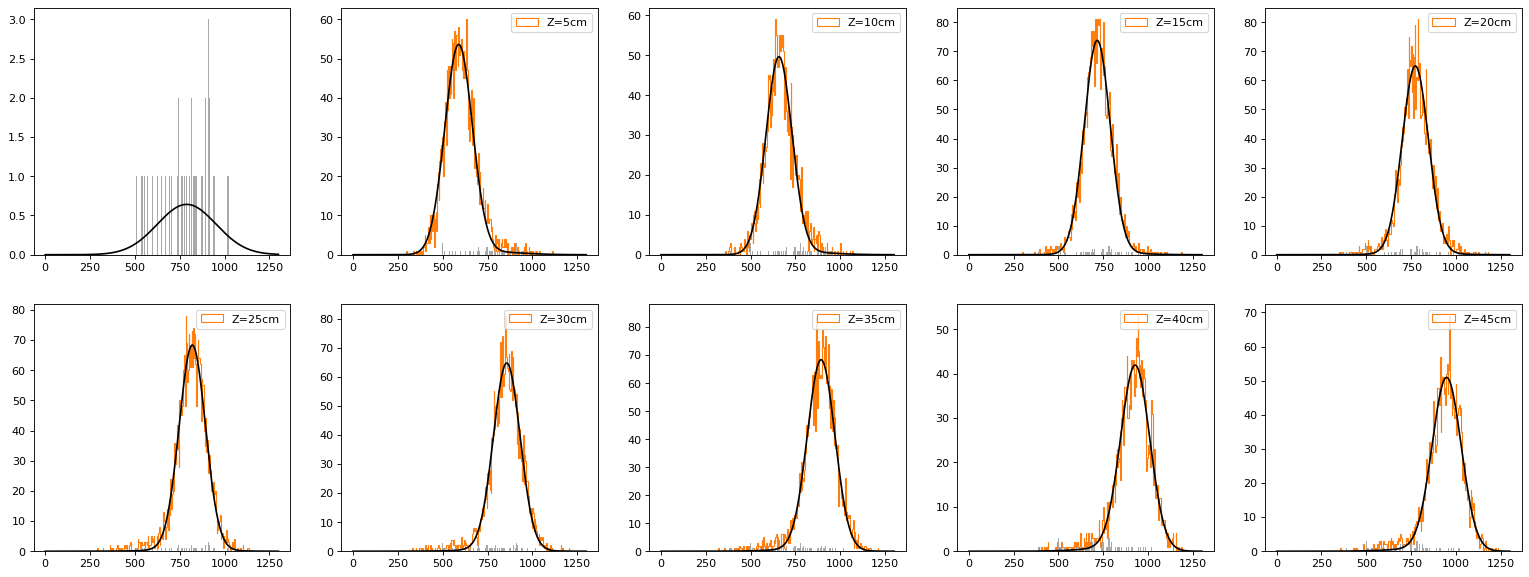

In [ ]:
#@title $\sigma_T$ for $900<R\leq 1000$
coi1000, dcoi1000 = fit_tsigma(roi.loc[(roi['R']<=1000) & (roi['R']>900)], 200)

'####################################################################################################'

BACKGROUND
A= 0.69+/-0.09
x0= 779+/-30
sigma= 192+/-33


'####################################################################################################'

Z =  5
A = 29.1+/-0.5
x0 =  593.9+/-1.7
sigma =  83.1+/-1.7


'####################################################################################################'

Z =  10
A = 28.4+/-0.6
x0 =  663.1+/-1.9
sigma =  79.1+/-1.9


'####################################################################################################'

Z =  15
A = 32.7+/-0.6
x0 =  720.3+/-1.6
sigma =  76.5+/-1.6


'####################################################################################################'

Z =  20
A = 35.1+/-0.7
x0 =  774.8+/-1.7
sigma =  74.9+/-1.7


'####################################################################################################'

Z =  25
A = 36.7+/-0.7
x0 =  817.2+/-1.6
sigma =  74.9+/-1.6


'####################################################################################################'

Z =  30
A = 31.5+/-0.6
x0 =  856.0+/-1.7
sigma =  75.8+/-1.7


'####################################################################################################'

Z =  35
A = 35.0+/-0.7
x0 =  891.1+/-1.8
sigma =  81.8+/-1.8


'####################################################################################################'

Z =  40
A = 20.1+/-0.5
x0 =  920.4+/-2.6
sigma =  87.1+/-2.6


'####################################################################################################'

Z =  45
A = 19.3+/-0.5
x0 =  948.2+/-2.6
sigma =  89.5+/-2.6


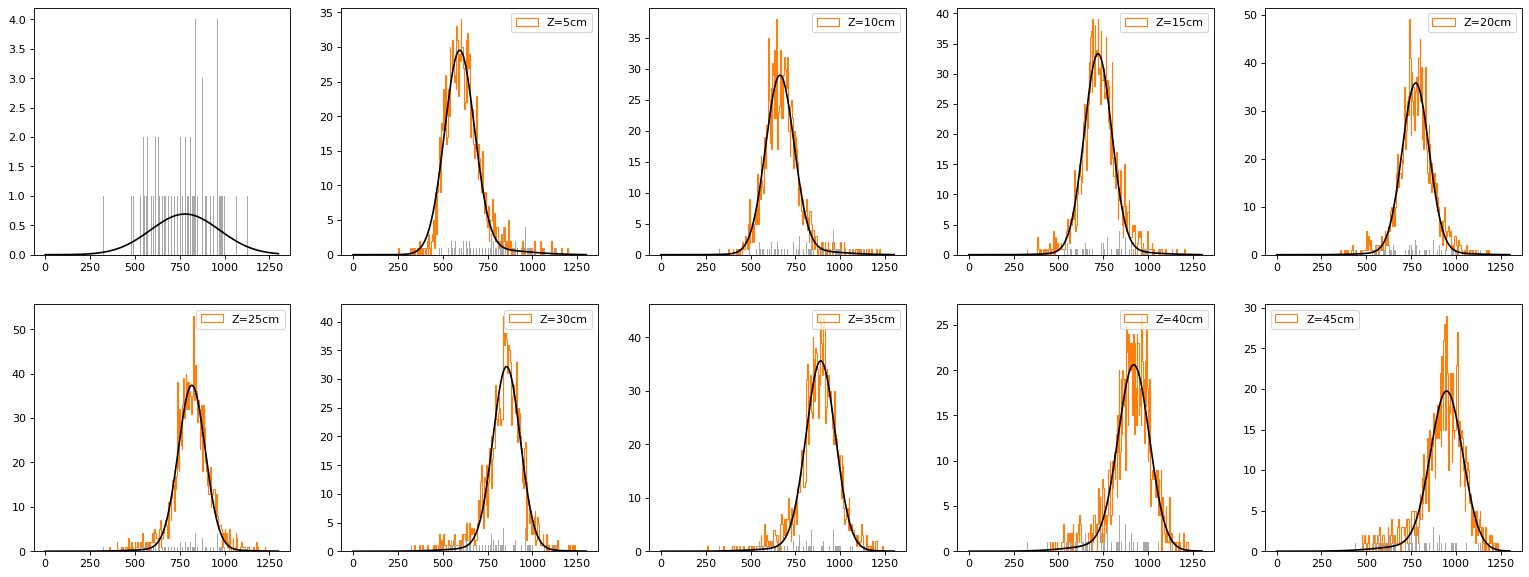

In [ ]:
#@title $\sigma_T$ for $1000<R\leq 1100$
coi1100, dcoi1100 = fit_tsigma(roi.loc[(roi['R']<=1100) & (roi['R']>1000)], 200)

## Results

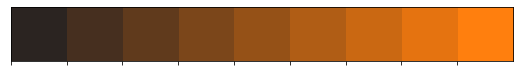

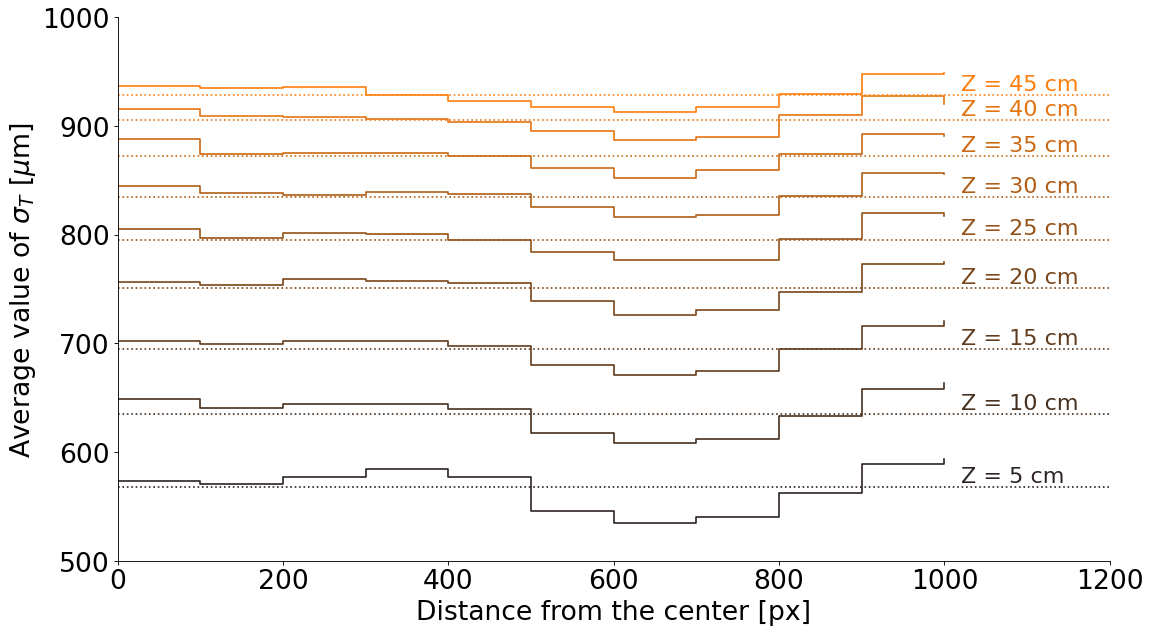

In [ ]:
#@title $\sigma_T$ in function of $R$

##@markdown The average value of $\sigma_T$ calculated for all the CoIs is almost the same as the one calculated for the central CoIs 

z = []
r = []
for d in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]:
  for Z in [5, 10, 15, 20, 25, 30, 35, 40, 45]: 
    z.append(Z)
    r.append(d)
sigma = coi100+coi200+coi300+coi400+coi500+coi600+coi700+coi800+coi900+coi1000+coi1100
dsigma = dcoi100+dcoi200+dcoi300+dcoi400+dcoi500+dcoi600+dcoi700+dcoi800+dcoi900+dcoi1000+dcoi1100
sigmaT = pd.DataFrame(list(zip(z, r, sigma, dsigma)), 
                    columns =['z[cm]', 'R[px]', 'TSigma', 'dTSigma']) 

color = get_color(9, 'tab:orange')

fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
i=0
for z in [5, 10, 15, 20, 25, 30, 35, 40, 45]:
  plt.step(sigmaT['R[px]'].loc[sigmaT['z[cm]']==z]-100, sigmaT['TSigma'].loc[sigmaT['z[cm]']==z], color=color[i], where='post')
  plt.text(1020, allcoi[i]+10, 'Z = '+str(z)+' cm', fontsize=20, color=color[i], va='center')
  plt.axhline(y=allcoi[i], color=color[i], ls=':')
  i = i+1

ax.set_xlim(0,1200)
ax.set_ylim(500,1000)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Average value of $\sigma_T$ [$\mu$m]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('Distance from the center [px]', x=0.5, ha='center', fontsize=24)

plt.show()

### Fitting the $\sigma_T$ profile in function of $z$

According to the CYGNO paper [[V.C. Antochi et al, 2020]](https://www.researchgate.net/profile/S-Tomassini/publication/341668419_A_GEM-based_Optically_Readout_Time_Projection_Chamber_for_charged_particle_tracking/links/5f2d3ec1299bf13404aba3e7/A-GEM-based-Optically-Readout-Time-Projection-Chamber-for-charged-particle-tracking.pdf), the ionisation electrons drifting in the gas are subjected to a longitudinal and transverse diffusion. Their arrival time and coordinates, $(x,y)$ are correlated with the point where they are produced. The standard deviations of the position at the anode, $\sigma_x$ and $\sigma_y$ are equal to $$\sqrt{\frac{2DZ}{\mu E}}$$
, where $D$ is the diffusion coefficient, $\mu$ the electron mobility and $E$, the drift electric field. 

Avalanche electrons also suffer additional diffusion during multiplication within the GEM holes.

The total diffusion is reflected in the transverse light distribution of each segment of the track: the $\sigma_T$ obtained from the Gaussian and related to the depth of interaction $z$ through: $$\sigma = \sqrt{\sigma_0^2+B^2z}$$
, where the transverse diffusion coefficient $B$ in the gas is 130 $\mu m\sqrt{cm}^{-1}$ (Garfield simulation), whereas the intercept at zero, $\sigma_0$, illustrates the contribution of the electron avalanche propagation in the GEM stack. 

B =  118.1+/-1.8
sigma0 =  517+/-10
RMSE =  9.43501592513947
B =  119.3+/-2.0
sigma0 =  525+/-11
RMSE =  10.380324083323748
B =  118.5+/-1.6
sigma0 =  520+/-9
RMSE =  8.655845397437155
B =  117.6+/-1.7
sigma0 =  528+/-9
RMSE =  8.898344173525373
B =  116.3+/-1.7
sigma0 =  535+/-9
RMSE =  9.085179440259754
B =  116.5+/-2.0
sigma0 =  528+/-11
RMSE =  10.335009459548644
B =  118.8+/-2.0
sigma0 =  493+/-12
RMSE =  10.781118752982579
B =  118.7+/-1.8
sigma0 =  481+/-11
RMSE =  9.861032815495259
B =  118.9+/-1.7
sigma0 =  485+/-10
RMSE =  9.32683230140694
B =  119.2+/-1.8
sigma0 =  511+/-11
RMSE =  9.936338040812682
B =  119.3+/-2.0
sigma0 =  525+/-11
RMSE =  10.380324083323748
B =  118.1+/-1.9
sigma0 =  549+/-10
RMSE =  10.037113022603853


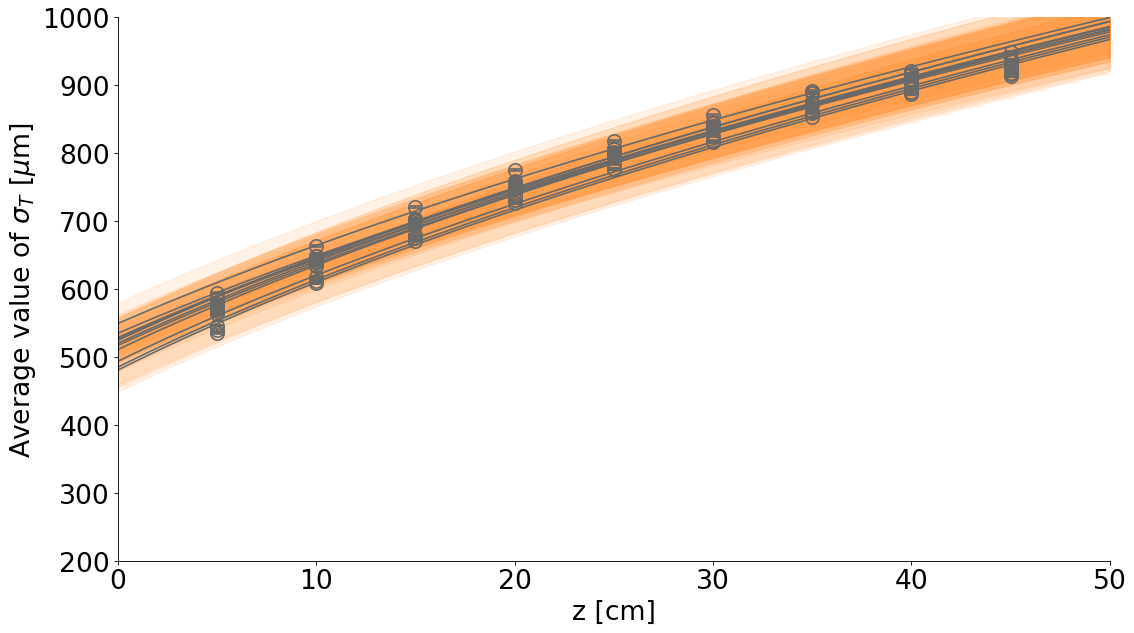

In [94]:
#@title Models of $\sigma_T(z)$

##@markdown I will use the $\sigma_T$ values calculated with all the CoIs

z = [5, 10, 15, 20, 25, 30, 35, 40, 45]

def func(z, b, c):
  return np.sqrt(z*b**2+c**2)

x = np.linspace(0,50, 100)

fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 

for (TSigma,dTSigma) in zip([allcoi, coi100, coi200, coi300, coi400, coi500, coi600, coi700, coi800, coi900, coi100, coi1100], 
                            [dallcoi, dcoi100, dcoi200, dcoi300, dcoi400, dcoi500, dcoi600, dcoi700, dcoi800, dcoi900, dcoi1000, dcoi1100]):
  popt, pcov = curve_fit(func, z, TSigma, p0=[100, 100])
  ycalc = func(x, *popt)
  pcov = np.sqrt(np.diag(pcov))
  bound_upper = func(x, *(popt + 3*pcov))
  bound_lower = func(x, *(popt - 3*pcov))

  print('B = ', ufloat(popt[0], pcov[0]))
  print('sigma0 = ', ufloat(popt[1], pcov[1]))
  rmse = np.sqrt(mean_squared_error(TSigma, func(np.asarray(z), *popt)))
  print('RMSE = ', rmse)
  plt.errorbar(z, TSigma, yerr=dTSigma, color='none', marker='o', markersize=12, 
            markeredgecolor='dimgray', markeredgewidth=1.5, ecolor='dimgray', elinewidth=1.5, capsize=5, capthick=1.5)
  plt.plot(x, ycalc, color='dimgray')
  plt.fill_between(x, bound_lower, bound_upper, color='tab:orange', alpha=0.1)

'''
#plt.plot(x, func(x, 129.7, 292), color='k')
#plt.fill_between(x, func(x, 129.7-2*3.1, 292-2*12), func(x, 129.7+2*3.1, 292+2*12), color='k', alpha=0.2)
#plt.text(1, 260, 'Trendline from V.C. Antochi et al., 2020', fontsize=22, ha='left')

plt.errorbar(z, TSigma, yerr=dTSigma, color='none', marker='o', markersize=12, 
            markeredgecolor='tab:orange', markeredgewidth=1.5, ecolor='tab:orange', elinewidth=1.5, capsize=5, capthick=1.5)
plt.fill_between(x, bound_lower, bound_upper, color='tab:orange', alpha=0.3)
plt.plot(x, ycalc, color='tab:orange')
plt.text(1, 950, "$\sigma_T (z)= \sqrt{517(10)^2+118.1(18)^2z}$ \nRMSE$=$"+str(round(rmse,2)), fontsize=22, ha='left', va='top', color='k', bbox=dict(facecolor='none', edgecolor='tab:orange', boxstyle='round,pad=0.5', lw=1.5))

'''
ax.set_xlim(0,50)
ax.set_ylim(200,1000)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Average value of $\sigma_T$ [$\mu$m]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('z [cm]', x=0.5, ha='center', fontsize=24)

plt.show()

B =  118.1+/-1.8
sigma0 =  517+/-10
RMSE =  9.43501592513947


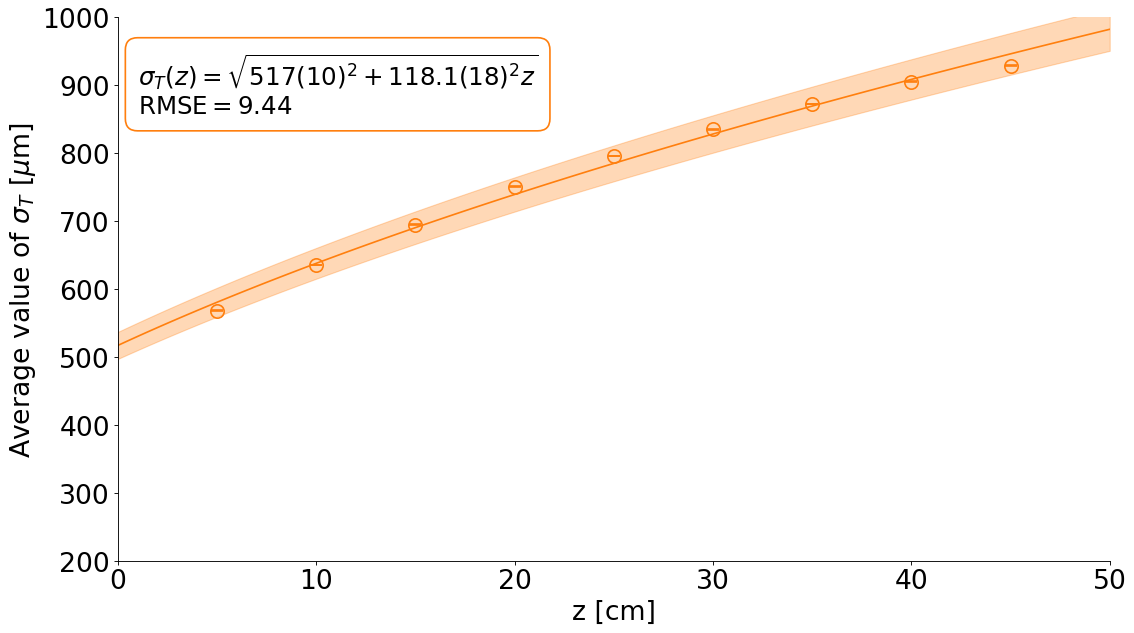

In [95]:
#@title Model of $\sigma_T(z)$ for all CoIs

z = [5, 10, 15, 20, 25, 30, 35, 40, 45]
TSigma = allcoi
dTSigma = dallcoi

def func(z, b, c):
  return np.sqrt(z*b**2+c**2)
x = np.linspace(0,50, 100)
popt, pcov = curve_fit(func, z, TSigma, p0=[100, 100])
ycalc = func(x, *popt)
pcov = np.sqrt(np.diag(pcov))
bound_upper = func(x, *(popt + 2*pcov))
bound_lower = func(x, *(popt - 2*pcov))

print('B = ', ufloat(popt[0], pcov[0]))
print('sigma0 = ', ufloat(popt[1], pcov[1]))
rmse = np.sqrt(mean_squared_error(TSigma, func(np.asarray(z), *popt)))
print('RMSE = ', rmse)

fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
#plt.plot(x, func(x, 129.7, 292), color='k')
#plt.fill_between(x, func(x, 129.7-2*3.1, 292-2*12), func(x, 129.7+2*3.1, 292+2*12), color='k', alpha=0.2)
#plt.text(1, 260, 'Trendline from V.C. Antochi et al., 2020', fontsize=22, ha='left')

plt.errorbar(z, TSigma, yerr=dTSigma, color='none', marker='o', markersize=12, 
            markeredgecolor='tab:orange', markeredgewidth=1.5, ecolor='tab:orange', elinewidth=1.5, capsize=5, capthick=1.5)
plt.fill_between(x, bound_lower, bound_upper, color='tab:orange', alpha=0.3)
plt.plot(x, ycalc, color='tab:orange')
plt.text(1, 950, "$\sigma_T (z)= \sqrt{517(10)^2+118.1(18)^2z}$ \nRMSE$=$"+str(round(rmse,2)), fontsize=22, ha='left', va='top', color='k', bbox=dict(facecolor='none', edgecolor='tab:orange', boxstyle='round,pad=0.5', lw=1.5))
ax.set_xlim(0,50)
ax.set_ylim(200,1000)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Average value of $\sigma_T$ [$\mu$m]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('z [cm]', x=0.5, ha='center', fontsize=24)

plt.show()